In [1]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
dir_name = "../ics_cwe/"
models = ["pretrained_SecBert", "SecBert_E5", "pretrained_SecureBert",  "SecureBert_E5", "pretrained_Gpt2","Gpt2_E5"]
text_embeddings = []
our_embeddings = []
text_matrix = []
our_emb_matrix = []
for model in models:
    text_embeddings.append(np.load(dir_name+model+"/data/all_embeddings.npy"))
    our_embeddings.append(np.load(dir_name+model+"/data/our_embeddings.npy"))
    text_matrix.append(cosine_similarity(text_embeddings[-1]))
    our_emb_matrix.append(cosine_similarity(our_embeddings[-1]))

In [3]:
text_matrix[0].shape

(1136, 1136)

In [4]:
our_emb_matrix[0].shape

(1136, 1136)

In [5]:
weakness_hop_sim_matrix = np.load('../ics_cwe/weakness_hop_sim_matrix.npy')
attack_hop_sim_matrix = np.load('../ics_cwe/attack_hop_sim_matrix.npy')

In [6]:
import numpy as np
def top_cosine_sim(cos_mat1):
    # Example cosine similarity matrix
    cosine_matrix = cos_mat1
    
    # Get the shape of the matrix
    N = cosine_matrix.shape[0]
    
    # Flatten the matrix while keeping track of the indices
    flattened_indices = np.argsort(cosine_matrix, axis=None)[::-1]
    
    # Convert the flattened indices back to row and column indices
    row_indices, col_indices = np.unravel_index(flattened_indices, (N, N))
    
    # Pair the row and column indices with their corresponding values
    sorted_pairs = [(row_indices[i], col_indices[i], cosine_matrix[row_indices[i], col_indices[i]]) 
                    for i in range(len(flattened_indices))]
    
    # Filter out pairs where the row index is greater than or equal to the column index to avoid duplicates
    # and exclude the diagonal elements (where row index == column index)
    # filtered_sorted_pairs = [(row, col, value) for row, col, value in sorted_pairs if row < col]
    filtered_sorted_pairs = [(row, col) for row, col, value in sorted_pairs if (row < 203 and col>=203)]
    
    # # Print the sorted pairs
    # count = 0
    # for row, col, value in filtered_sorted_pairs:
    #     print(f"({row}, {col}) -> {value}")
    #     count+=1
    #     if(count>10):
    #         break
    return filtered_sorted_pairs

In [7]:
text_sorted_pairs = []
for i in range(len(models)):
    text_sorted_pairs.append(top_cosine_sim(text_matrix[i]))

In [8]:

our_sorted_pairs = []
for i in range(len(models)):
    our_sorted_pairs.append(top_cosine_sim(our_emb_matrix[i]))

In [393]:
text_sorted_pairs[0][500:520]

[(148, 974),
 (148, 373),
 (147, 526),
 (104, 244),
 (103, 792),
 (143, 862),
 (177, 797),
 (103, 585),
 (106, 899),
 (64, 1024),
 (132, 540),
 (106, 550),
 (104, 437),
 (105, 391),
 (170, 1055),
 (106, 548),
 (71, 855),
 (132, 1105),
 (143, 244),
 (103, 848)]

In [9]:
import json
with open('../ics_cwe/id_to_pos.json') as fp:
    id_to_pos = json.load(fp)
with open('../ics_cwe/pos_to_id.json') as fp:
    pos_to_id = json.load(fp)

In [10]:
import json
import networkx as nx

# Load the JSON data again
with open('../../graph_network/graph_0.json', 'r') as file:
    a_graph_data = json.load(file)

In [11]:
with open('../../graph_network/graph_Weakness.json') as f:
    w_graph_data = json.load(f)

In [12]:
def get_index_id_mapping(graph, isAttack):
    mapping = {}
    id_tag = 'ID'
    if(isAttack):
        id_tag = 'id'
    for i in range(len(graph['nodes'])):
        mapping[graph['nodes'][i][id_tag]]=i
    return mapping

In [13]:
attack_map = get_index_id_mapping(a_graph_data, True)
weakness_map = get_index_id_mapping(w_graph_data, False)

In [14]:
# 138-[622-619]
# 64-[689-688]

In [15]:
weakness_map[pos_to_id['622']]

419

In [16]:
def getConnectedWeak(w_pos):
    w_id = pos_to_id[str(w_pos)]
    # print(w_id)
    res_set = set()
    for i in range(len(w_graph_data['links'])):
        
        if(w_graph_data['links'][i]['target']==w_id):
            # print(w_graph_data['links'][i]['source'])
            res_set.add(id_to_pos[w_graph_data['links'][i]['source']])
        if(w_graph_data['links'][i]['source']==w_id):
            # print(w_graph_data['links'][i]['target'])
            res_set.add(id_to_pos[w_graph_data['links'][i]['target']])
    return res_set

In [17]:
# getConnectedWeak(203)

In [18]:
def getTopNeighborPos(text_sorted_pairs,our_sorted_pairs,model,k=5):
    position_in_text = []
    position_in_our = []

    # Store the sorted rows to avoid recomputing them
    our_sorted_rows = {}
    text_sorted_rows = {}

    intersect_pairs = list(set(text_sorted_pairs[model][:k])& set(our_sorted_pairs[model][:k]))
    
    #for a, w in intersect_pairs:
    for a, w in intersect_pairs:
        w_set = list(getConnectedWeak(w))
        our_pos_sum = 0
        text_pos_sum = 0
        
        for wneigh in w_set:
            # Cache the sorted rows to avoid recomputation
            if wneigh not in our_sorted_rows:
                our_sorted_rows[wneigh] = np.argsort(our_emb_matrix[model][wneigh][:203])[::-1]
            if wneigh not in text_sorted_rows:
                text_sorted_rows[wneigh] = np.argsort(text_matrix[model][wneigh][:203])[::-1]
            
            our_sort = our_sorted_rows[wneigh]
            text_sort = text_sorted_rows[wneigh]

            our_pos = np.where(our_sort == a)[0][0]
            text_pos = np.where(text_sort == a)[0][0]

            our_pos_sum += our_pos
            text_pos_sum += text_pos

        position_in_our.append(our_pos_sum / len(w_set))
        position_in_text.append(text_pos_sum / len(w_set))

    return position_in_our, position_in_text
        

In [522]:
position_in_our, position_in_text = getTopNeighborPos(text_sorted_pairs,our_sorted_pairs,5,k=1000)

In [523]:
len(position_in_our)

189

In [524]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute medians for specified ranges
def compute_medians(data, range_size):
    medians = []
    for i in range(0, len(data), range_size):
        median = np.mean(data[i:i + range_size])
        medians.append(median)
    return medians

def plot_pos_comparison(position_in_our, position_in_text):
    # Dummy data for demonstration purposes (replace with actual data)
    # Define range size
    range_size = 20
    
    # Compute medians
    medians_in_our = compute_medians(position_in_our, range_size)
    medians_in_text = compute_medians(position_in_text, range_size)
    num_ranges = len(medians_in_our)
    range_labels = [f'{i*range_size}-{(i+1)*range_size}' for i in range(num_ranges)]
    # Plotting the data
    plt.figure(figsize=(5, 3))
    plt.plot(medians_in_our, label='Mean Ranking by AWEB F. Gpt2', marker='o')
    plt.plot(medians_in_text, label='Mean Ranking by Text Embd. F. Gpt2', marker='x')
    
    # Adding titles and labels
    #plt.title('Median Comparison of Positions in Our Embedding and Text Embedding')
    plt.xlabel('Top K att&ck-weakness pairs')
    plt.ylabel('Mean Ranking Position')
    plt.xticks(ticks=range(num_ranges), labels=range_labels, rotation=45)
    plt.legend()
    plt.grid(True)
    plt.savefig(dir_name+"plots/mean_ranking_secureBert.pdf", dpi=300, bbox_inches='tight')
    # Show the plot
    plt.show()

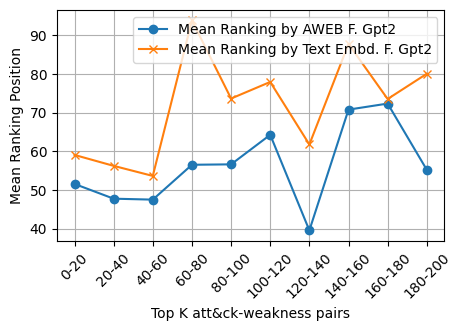

In [525]:
plot_pos_comparison(position_in_our, position_in_text)

In [80]:
for i in range(len(w_graph_data['links'])):
    if(w_graph_data['links'][i]['target']=='732'):
        print(w_graph_data['links'][i]['source'])
    if(w_graph_data['links'][i]['source']=='732'):
        print(w_graph_data['links'][i]['target'])

1004
276
276
277
278
279
281
281
285
668
766


In [19]:
a_graph_data['nodes'][attack_map[pos_to_id['64']]]

{'modified': '2023-03-09T18:38:51.471Z',
 'name': 'Network Sniffing',
 'description': 'Network sniffing is the practice of using a network interface on a computer system to monitor or capture information (Citation: Enterprise ATT&CK January 2018) regardless of whether it is the specified destination for the information. \n\nAn adversary may attempt to sniff the traffic to gain information about the target. This information can vary in the level of importance. Relatively unimportant information is general communications to and from machines.  Relatively important information would be login information. User credentials may be sent over an unencrypted protocol, such as Telnet, that can be captured and obtained through network packet analysis. \n\nIn addition, ARP and Domain Name Service (DNS) poisoning can be used to capture credentials to websites, proxies, and internal systems by redirecting traffic to an adversary.',
 'kill_chain_phases': [{'kill_chain_name': 'mitre-ics-attack',
   'p

In [21]:
w_graph_data['nodes'][weakness_map[pos_to_id['689']]]

{'ID': '291',
 'Name': 'Reliance on IP Address for Authentication',
 'Abstraction': 'Variant',
 'Structure': 'Simple',
 'Status': 'Incomplete',
 'Description': 'The product uses an IP address for authentication.',
 'Extended_Description': 'IP addresses can be easily spoofed. Attackers can forge the source IP address of the packets they send, but response packets will return to the forged IP address. To see the response packets, the attacker has to sniff the traffic between the victim machine and the forged IP address. In order to accomplish the required sniffing, attackers typically attempt to locate themselves on the same subnet as the victim machine. Attackers may be able to circumvent this requirement by using source routing, but source routing is disabled across much of the Internet today. In summary, IP address verification can be a useful part of an authentication scheme, but it should not be the single factor required for authentication.',
 'Related_Weaknesses': [{'Nature': 'Chi

In [66]:
id_to_pos['573']

220

In [67]:
w_graph_data['nodes'][weakness_map['732']]

{'ID': '732',
 'Name': 'Incorrect Permission Assignment for Critical Resource',
 'Abstraction': 'Class',
 'Structure': 'Simple',
 'Status': 'Draft',
 'Description': 'The product specifies permissions for a security-critical resource in a way that allows that resource to be read or modified by unintended actors.',
 'Extended_Description': 'When a resource is given a permission setting that provides access to a wider range of actors than required, it could lead to the exposure of sensitive information, or the modification of that resource by unintended parties. This is especially dangerous when the resource is related to program configuration, execution, or sensitive user data. For example, consider a misconfigured storage account for the cloud that can be read or written by a public or anonymous user.',
 'Related_Weaknesses': [{'Nature': 'ChildOf',
   'CWE_ID': '285',
   'View_ID': '1000',
   'Ordinal': 'Primary'},
  {'Nature': 'ChildOf', 'CWE_ID': '668', 'View_ID': '1000'}],
 'Likeliho

In [64]:
id_to_pos['552']

619

In [35]:
a = np.argsort(our_emb_matrix[0][688][:203])[::-1]
np.where(a==64)

(array([53]),)

In [36]:
a = np.argsort(our_emb_matrix[0][688][:203])[::-1]
np.where(a==64)
a = np.argsort(text_matrix[0][688][:203])[::-1]
np.where(a==64)

(array([72]),)

In [88]:
1136-517

619

In [89]:
1136-1055

81

In [124]:
def get_top(cosine_matrix, k):
    # Flatten the matrix while keeping track of the indices
    flattened_indices = np.argsort(cosine_matrix, axis=None)[::-1]
    
    # Initialize an empty list to store the valid top 10 pairs
    valid_top_indices = []
    
    # Loop over the sorted indices to filter out diagonal elements
    for flat_index in flattened_indices:
        row, col = np.unravel_index(flat_index, cosine_matrix.shape)
        if (row != col) and ((row<203 and col>203)):
            valid_top_indices.append((row, col))
        if len(valid_top_indices) == k:
            break
    
    # Print the row and column indices of the top 10 maximum values (excluding diagonal)
    print(f"Row and column indices of the top {k} maximum values (excluding diagonal): {valid_top_indices}")
    
    # Optionally, print the corresponding values
    top_values = [cosine_matrix[row, col] for row, col in valid_top_indices]
    print(f"Top {k} maximum values (excluding diagonal): {top_values}")
    return valid_top_indices

In [137]:
top1 = get_top(our_emb_matrix[0],50)

Row and column indices of the top 50 maximum values (excluding diagonal): [(55, 609), (9, 609), (117, 481), (27, 1121), (9, 608), (112, 974), (147, 1105), (156, 707), (55, 608), (64, 1121), (72, 903), (47, 608), (59, 1121), (150, 1105), (64, 689), (45, 953), (41, 609), (108, 1048), (69, 608), (17, 660), (147, 708), (93, 609), (176, 974), (9, 433), (117, 607), (66, 481), (23, 676), (27, 689), (62, 973), (156, 902), (62, 750), (172, 831), (41, 1105), (117, 606), (123, 1105), (24, 402), (62, 692), (80, 410), (34, 410), (109, 609), (109, 1105), (31, 708), (23, 677), (136, 440), (170, 903), (93, 1020), (147, 425), (23, 675), (147, 608), (78, 700)]
Top 50 maximum values (excluding diagonal): [0.90922165, 0.89574367, 0.891054, 0.8893047, 0.8890803, 0.8748248, 0.87027353, 0.86971503, 0.8627675, 0.8622357, 0.8567123, 0.8556904, 0.8545036, 0.85385674, 0.8532069, 0.8510028, 0.85087425, 0.8439738, 0.8435763, 0.8424997, 0.8399693, 0.8393638, 0.8389293, 0.8387298, 0.8375761, 0.8367665, 0.836677, 0.8

In [138]:
top2 = get_top(text_matrix[0],50)

Row and column indices of the top 50 maximum values (excluding diagonal): [(64, 689), (112, 393), (64, 700), (37, 609), (123, 390), (74, 797), (5, 708), (176, 393), (43, 425), (64, 1121), (123, 1020), (109, 390), (64, 797), (74, 689), (85, 425), (177, 538), (137, 700), (45, 390), (69, 390), (5, 390), (71, 708), (47, 609), (74, 700), (10, 1020), (55, 609), (109, 609), (150, 425), (177, 425), (21, 425), (121, 797), (43, 708), (9, 609), (10, 425), (69, 425), (10, 1025), (112, 425), (68, 708), (45, 1120), (10, 390), (45, 209), (5, 425), (105, 391), (64, 725), (55, 215), (69, 609), (45, 1014), (47, 390), (167, 538), (85, 393), (123, 901)]
Top 50 maximum values (excluding diagonal): [0.7224605577264848, 0.6961045823242791, 0.6855438816290164, 0.6817153199707007, 0.6815209218783034, 0.68150253837665, 0.6788426776620691, 0.6786281365870481, 0.6779542877290493, 0.674740289963606, 0.6735925008230782, 0.6689157415709652, 0.666410579994802, 0.6663217070562745, 0.6636631367016123, 0.662195098308637

In [139]:
our_emb_matrix[0][64][689]

0.8532069

In [140]:
set(top1) & set(top2)

{(9, 609), (55, 609), (64, 689), (64, 1121), (109, 609)}